# Top Charts Song Classification

## Outline
1. <a href='#1'>Introduction</a>
2. <a href='#2'>Dataset Setup</a>
3. <a href='#3'>Results</a>
4. <a href='#4'>Discussion</a>

## 1. Introduction

## 2. Dataset Setup

### Imports

In [509]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from spotipy import Spotify, oauth2
import secret
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import time
import math
from datetime import datetime


In [428]:
def import_data():
    """
    Import all the song data from raw, unedited csv within this folder
    Returns csv as a dataframe object (still uncleaned)
    Link to Dataset on Kaggle: https://www.kaggle.com/datasets/multispiros/34740-hit-and-nonhit-songs-spotify-features?resource=download
    """
    unedited_song_data = pd.read_csv('unedited_song_data.csv')
    return unedited_song_data

### Spotify API Setup

In [429]:
artist_popularities = {} # concatenate artist popularities from all class instances

class SpotifyAPI:
    def __init__(self, client_id: str, client_secret: str):
        """
        Create a SpotifyAPI object
        :param client_id: Your Spotify client ID
        :param client_secret: Your Spotify client secret
        """
        credentials_manager = oauth2.SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
        self.sp = Spotify(client_credentials_manager=credentials_manager)
        self.artist_popularity = pd.DataFrame(columns=['Track ID', 'Artist ID', 'Artist Popularity'])
        self.tracks = []
        self.artists = []
    
    def get_tracks(self, track_ids):
        if (len(track_ids) > 50): raise Exception("Limit is 50 tracks")

        try:
            track_objects = self.sp.tracks(tracks=track_ids)
            time.sleep(30)
        except Exception as se:
            print("Error details: {}".format(se))
            time.sleep(30)
        
        actual_tracks = track_objects['tracks']
        self.tracks.extend(actual_tracks)
        return actual_tracks
    
    def get_artist_popularity(self, track_ids):
        track_objects = self.get_tracks(track_ids)
        artist_ids = []
        artist_popularities = []
        for track in track_objects:
            primary_artist_id = track['artists'][0]['id']
            artist_ids.append(primary_artist_id)

        try:
            artist_objects_dict = self.sp.artists(artists=artist_ids)
            time.sleep(30)
        except Exception as se:
            print("Error details: {}".format(se))
            time.sleep(30)
        
        artist_objects = artist_objects_dict['artists']
        self.artists.extend(artist_objects)
        
        for artist in artist_objects:
            artist_popularities.append(artist['popularity'])
            
        artist_pop_df = pd.DataFrame({'Track ID': track_ids, 'Artist ID': artist_ids, 'Artist Popularity': artist_popularities})
        self.artist_popularity = pd.concat([self.artist_popularity, artist_pop_df], ignore_index=True)
        print('---artist_popularity length', len(self.artist_popularity))


#### Spotify API Clients

In [430]:
spotify_api_0 = SpotifyAPI(client_id=secret.spotify_client_id_tester, client_secret=secret.spotify_secret_key_tester)
spotify_api_1 = SpotifyAPI(client_id=secret.spotify_client_id_1, client_secret=secret.spotify_secret_key_1)
spotify_api_2 = SpotifyAPI(client_id=secret.spotify_client_id_2, client_secret=secret.spotify_secret_key_2)
spotify_api_3 = SpotifyAPI(client_id=secret.spotify_client_id_3, client_secret=secret.spotify_secret_key_3)
spotify_api_4 = SpotifyAPI(client_id=secret.spotify_client_id_4, client_secret=secret.spotify_secret_key_4)

In [431]:
spotify_clients = [spotify_api_0, spotify_api_1, spotify_api_2, spotify_api_3, spotify_api_4]

In [432]:
unedited_song_data = import_data()
test_cleaned_song_data = unedited_song_data.copy().dropna()
del test_cleaned_song_data['track_title']
del test_cleaned_song_data['key']
del test_cleaned_song_data['time_signature']

test_cleaned_song_data['artist_name'] = test_cleaned_song_data['artist_name'].str.strip()
dups_removed = test_cleaned_song_data.drop_duplicates(subset=['artist_name']).reset_index()

In [433]:
fifths = np.array_split(dups_removed, 5)

In [434]:
def split_dataframe(df, chunk_size = 50): 
    chunks = []
    num_chunks = math.ceil(len(df) / chunk_size)
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [435]:
test_df = split_dataframe(fifths[0])

In [436]:
test_list = test_df[1].track_id
test_list = test_list.tolist()
# spotify_api_0.get_artist_popularity(test_list)

In [437]:
spotify_api_0.artist_popularity

,Track ID,Artist ID,Artist Popularity


In [438]:
def process_dataset_portion(idx):
    api = spotify_clients[idx]
    dataset_portion = fifths[idx]
    
    # Split dataframe into chunks of 50 to adhere to rate/size limit
    dataset_chunks = split_dataframe(dataset_portion)
    print('----------------------api:', idx, '   start:', datetime.now().strftime("%H:%M:%S"))
    i = 1
    for subset in dataset_chunks:
        track_ids = subset.track_id
        track_id_list = track_ids.tolist()
        api.get_artist_popularity(track_id_list)
        print('api:', idx, '   finished:', i)
        i+=1
    print('-----------------------api:', idx, '   end:', datetime.now().strftime("%H:%M:%S"))

In [439]:
# Sumana: 0, 1, 2
# process_dataset_portion(0)
# spotify_api_0.artist_popularity

In [440]:
# process_dataset_portion(1)
# spotify_api_1.artist_popularity

In [441]:
# process_dataset_portion(2)
# spotify_api_2.artist_popularity

In [442]:
# Gerri: 3 & 4
# Note: the spotify_api_3 etc. instance's .artist_popularity param will have the dataframe
# process_dataset_portion(3)

### Data Cleaning Methods

In [458]:
def clean_data(unedited_song_data):
    """
    Cleans the given csv by removing not helpful features from our database and
    replaces the artist_name column with the artist popularity metric from the
    Spotify API
    Returns the cleaned DataFrame
    :param unedited_song_data: the unedited and uncleaned DataFrame object
    """
    cleaned_song_data = unedited_song_data.copy().dropna()
    del cleaned_song_data['track_title']
    del cleaned_song_data['key']
    del cleaned_song_data['time_signature']
    
#     cleaned_song_data['artist_name'] = cleaned_song_data['artist_name'].str.strip()
    # cleaned_song_data = add_popularity_info(cleaned_song_data)

    del cleaned_song_data['artist_name']
    del cleaned_song_data['track_id']

    return cleaned_song_data
    

In [468]:
def scale_train_test_x(train, test, scaler = None):
    '''
    Standardizes the given train and test data.
    Returns the scaled train and test data
    :param train: the training data to scale
    :param test: the testing data to scale
    :param scaler: the scaler to use to standardize, else default is StandardScaler
    '''
    if scaler is None:
        scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    return train, test

In [469]:
def split_data(cleaned_song_data):
    """
    Splits the training data into a 75%/25% split with the 25% allotted for testing
    Scales the training data before using it to fit models
    Returns the data split into x_train, x_test, y_train and y_test
    :param cleaned_song_data: the cleaned DataFrame object 
    """
    song_y = cleaned_song_data['On_chart']
    song_x = cleaned_song_data.drop(['On_chart'], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(song_x, song_y, test_size=0.25, random_state=5)
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    x_train, x_test = scale_train_test_x(x_train, x_test)
    return x_train, x_test, y_train, y_test

### Cleaning the Data

In [470]:
uncleaned_song_data = import_data()

In [471]:
uncleaned_song_data

,track_title,artist_name,track_id,duration_ms,energy,key,mode,time_signature,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,valence,tempo,On_chart
0,Red Planet - Red Planet Radio,Joe,3FeufAV1f6fajILIQuAXMw,256080,0.96800,7,0,4,0.02150,0.698,0.862000,0.1110,-11.012,0.0337,0.3900,136.884,0
1,Red Planet - Red Planet Extended,Joe,2o7oYjZuo3S2QitY4R5dII,395442,0.97000,2,1,4,0.00339,0.724,0.896000,0.1060,-8.415,0.0358,0.4320,136.868,0
2,Basejump,Robin Schulz,6nWoNNkfffbmHU9z3kGPao,391680,0.40600,5,0,4,0.00433,0.803,0.825000,0.0948,-9.444,0.0608,0.0769,125.014,0
3,"Goldberg Variations, BWV 988 (Arr. for Accordi...",Johann Sebastian Bach,5Zg1UOcmee5oiRw3gbXna0,347840,0.00267,7,0,5,0.91000,0.150,0.028700,0.1250,-24.701,0.0434,0.1050,135.652,0
4,"Goldberg Variations, BWV 988 (Arr. for Accordi...",Johann Sebastian Bach,2ZWmWGoZS2OTGZSnMhck7Q,181733,0.22600,7,1,4,0.76800,0.290,0.000002,0.1050,-14.990,0.0385,0.4700,98.348,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34735,Además de Mí - Remix,Rusherking,7I8L3vYCLThw2FDrE6LuzE,330040,0.61300,6,1,4,0.03960,0.397,0.000000,0.1920,-5.077,0.0549,0.4050,78.400,1
34736,Drunk,Elle King & Miranda Lambert,0QULNNd9z5s35entfiiXoa,245626,0.88400,5,1,4,0.00516,0.612,0.000000,0.0997,-4.400,0.0459,0.6260,119.991,1
34737,Breaking Up Was Easy In The 90's,Sam Hunt,4sf2L157iEgAR7yrCNLgSq,215933,0.64900,9,1,4,0.23100,0.562,0.000000,0.3410,-5.400,0.0494,0.3760,145.913,1
34738,Nobody,Dylan Scott,5TWAIHYaOnYg4txfmCgon5,160707,0.74700,0,1,4,0.51900,0.573,0.000001,0.0867,-6.460,0.0319,0.6450,79.952,1


In [472]:
uncleaned_song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34740 entries, 0 to 34739
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_title       34739 non-null  object 
 1   artist_name       34739 non-null  object 
 2   track_id          34740 non-null  object 
 3   duration_ms       34740 non-null  int64  
 4   energy            34740 non-null  float64
 5   key               34740 non-null  int64  
 6   mode              34740 non-null  int64  
 7   time_signature    34740 non-null  int64  
 8   acousticness      34740 non-null  float64
 9   danceability      34740 non-null  float64
 10  instrumentalness  34740 non-null  float64
 11  liveness          34740 non-null  float64
 12  loudness          34740 non-null  float64
 13  speechiness       34740 non-null  float64
 14  valence           34740 non-null  float64
 15  tempo             34740 non-null  float64
 16  On_chart          34740 non-null  int64 

In [473]:
cleaned_song_data = clean_data(uncleaned_song_data)

In [474]:
cleaned_song_data

,duration_ms,energy,mode,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,valence,tempo,On_chart
0,256080,0.96800,0,0.02150,0.698,0.862000,0.1110,-11.012,0.0337,0.3900,136.884,0
1,395442,0.97000,1,0.00339,0.724,0.896000,0.1060,-8.415,0.0358,0.4320,136.868,0
2,391680,0.40600,0,0.00433,0.803,0.825000,0.0948,-9.444,0.0608,0.0769,125.014,0
3,347840,0.00267,0,0.91000,0.150,0.028700,0.1250,-24.701,0.0434,0.1050,135.652,0
4,181733,0.22600,1,0.76800,0.290,0.000002,0.1050,-14.990,0.0385,0.4700,98.348,0
...,...,...,...,...,...,...,...,...,...,...,...,...
34735,330040,0.61300,1,0.03960,0.397,0.000000,0.1920,-5.077,0.0549,0.4050,78.400,1
34736,245626,0.88400,1,0.00516,0.612,0.000000,0.0997,-4.400,0.0459,0.6260,119.991,1
34737,215933,0.64900,1,0.23100,0.562,0.000000,0.3410,-5.400,0.0494,0.3760,145.913,1
34738,160707,0.74700,1,0.51900,0.573,0.000001,0.0867,-6.460,0.0319,0.6450,79.952,1


In [475]:
cleaned_song_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34739 entries, 0 to 34739
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration_ms       34739 non-null  int64  
 1   energy            34739 non-null  float64
 2   mode              34739 non-null  int64  
 3   acousticness      34739 non-null  float64
 4   danceability      34739 non-null  float64
 5   instrumentalness  34739 non-null  float64
 6   liveness          34739 non-null  float64
 7   loudness          34739 non-null  float64
 8   speechiness       34739 non-null  float64
 9   valence           34739 non-null  float64
 10  tempo             34739 non-null  float64
 11  On_chart          34739 non-null  int64  
dtypes: float64(9), int64(3)
memory usage: 3.4 MB


### Training Models

In [476]:
def predict_model(model, x):
    '''
    Predicts the y values for the given x values using the given model.
    Returns the Y predictions
    :param model: the trained model to use for our prediction
    :param x: x data to get y predictions for
    '''
    y_pred = model.predict(x);
    return y_pred

In [522]:
def fit_classifier(classifier, x_train, y_train, num_estimators=100):
    '''
    Trains a random forest classifier ensemble using the given x and y training data
    Returns the trained random forest model
    :param x_train: the x data to train our random forest model on
    :param y_train: the y data to train our random forest model on
    '''
    if (classifier == 'RandomForest'):
        cl = RandomForestClassifier(n_estimators=num_estimators)
    elif (classifier == 'AdaBoost'):
        cl = AdaBoostClassifier(n_estimators=num_estimators)
    cl.fit(x_train, y_train)
    return cl

In [519]:
def get_metrics(model, x_test, y_true, y_pred):
    '''
    Gets evaluation metrics confusion matrix, classification report, accuracy sore, precision score,
    recall score, f1 score and auc score
    for the given y true and y predicted values.
    Returns the confusion matrix, the classification report, the accuracy score, precision score,
    recall score, f1 score and the auc score
    :param model: the model we are getting metrics for based on its predictions
    :param x_test: the testing data we used to predict from
    :param y_true: the true y data 
    :param y_pred: the y data predicted by the model
    '''
    conf_matrix = confusion_matrix(y_true,y_pred)
    class_report = classification_report(y_true,y_pred)
    accuracy = accuracy_score(y_true,y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_sc = f1_score(y_true, y_pred)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    auc = roc_auc_score(y_true, y_pred_proba)
    return conf_matrix, class_report, accuracy, precision, recall, f1_sc, auc

    

In [520]:
## Split data to be used for training / testing for each model
actual_unedited_song_data = import_data()
actual_cleaned_song_data = clean_data(actual_unedited_song_data)
x_train, x_test, y_train, y_test = split_data(actual_cleaned_song_data)

In [532]:
n_estimators = range(1, 51)

def run_ensemble_classifier(classifier):
    metrics_test = []
    
    for ne in n_estimators:
        fit_cl = fit_classifier(classifier, x_train, y_train, ne)

        y_pred = predict_model(fit_cl, x_test)

        conf_matrix, class_report, accuracy, precision, recall, f1_sc, auc = get_metrics(fit_cl, x_test, y_test, y_pred)

        metrics_test.append({
            '# Trees': ne,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_sc,
            'AUC':auc
        })
    
    return pd.DataFrame(metrics_test).set_index('# Trees')
    

#### Random Forest Ensemble

In [533]:
rf_metrics = run_ensemble_classifier('RandomForest')

In [534]:
print('Random Forest Classifier Metrics - Test Set')
rf_metrics

Random Forest Classifier Metrics - Test Set


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
1,0.740012,0.740442,0.739761,0.740101,0.740012
2,0.706966,0.800869,0.551542,0.653223,0.794609
3,0.768336,0.762365,0.780258,0.771208,0.824688
4,0.764076,0.801523,0.702485,0.748743,0.844209
5,0.783765,0.774222,0.801657,0.787701,0.852445
6,0.776396,0.799452,0.738380,0.767703,0.856951
7,0.792170,0.777099,0.819834,0.797895,0.864986
8,0.787795,0.799330,0.768983,0.783863,0.869225
9,0.799194,0.783195,0.827888,0.804922,0.876648


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Random Forest Ensemble Evaluation Metrics Based on Number of Estimators')

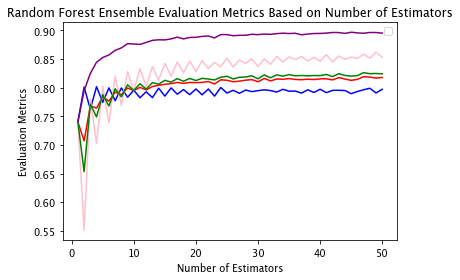

In [535]:
## plot all evaluation metrics as y values with estimator as x 
plt.plot(n_estimators, rf_metrics.Accuracy, color="red")
plt.plot(n_estimators, rf_metrics.Precision, color="blue")
plt.plot(n_estimators, rf_metrics.Recall, color="pink")
plt.plot(n_estimators, rf_metrics['F1 Score'], color="green")
plt.plot(n_estimators, rf_metrics.AUC, color="purple")
plt.legend()
plt.xlabel('Number of Estimators')
plt.ylabel('Evaluation Metrics')
plt.title('Random Forest Ensemble Evaluation Metrics Based on Number of Estimators')

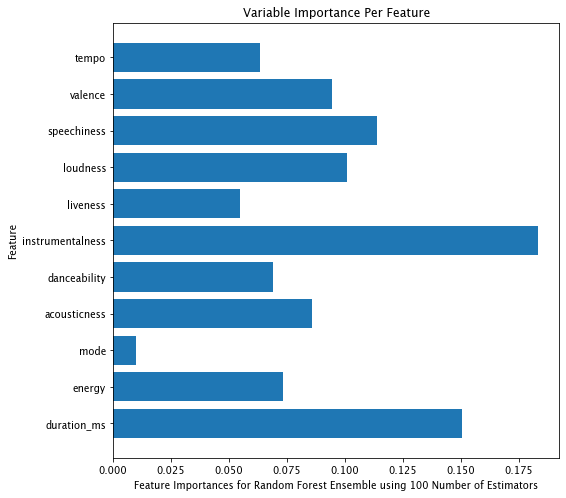

In [508]:
## plot feature importance of random forest using ensemble trained on best number of estimators to use as determined previous
rfc = train_random_forest(x_train, y_train, 100)
importances = rfc.feature_importances_


features = actual_cleaned_song_data.drop(['On_chart'], axis=1).columns

y_pos = np.arange(len(features))

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

ax.barh(y_pos, importances)
ax.set_title('Variable Importance Per Feature')
ax.set_ylabel('Feature')
ax.set_xlabel('Feature Importances for Random Forest Ensemble using 100 Number of Estimators')
ax.set_yticks(y_pos, features)
plt.show()

#### Random Forest Ensemble Analysis

Best number of estimators to use: 

## AdaBoost

In [536]:
ada_metrics = run_ensemble_classifier('AdaBoost')

In [537]:
print('AdaBoost Classifier Metrics - Test Set')
ada_metrics

AdaBoost Classifier Metrics - Test Set


,Accuracy,Precision,Recall,F1 Score,AUC
# Trees,,,,,
1,0.699367,0.631181,0.960423,0.761748,0.699156
2,0.738054,0.673829,0.923608,0.779191,0.747112
3,0.738054,0.673829,0.923608,0.779191,0.799844
4,0.761773,0.723894,0.846986,0.780617,0.821526
5,0.768451,0.734768,0.840773,0.784204,0.829775
6,0.764767,0.718211,0.872066,0.787696,0.839143
7,0.768336,0.734620,0.840773,0.784120,0.843383
8,0.767645,0.737842,0.830879,0.781602,0.847304
9,0.768106,0.729618,0.852508,0.786290,0.848473


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'AdaBoost Evaluation Metrics Based on Number of Estimators')

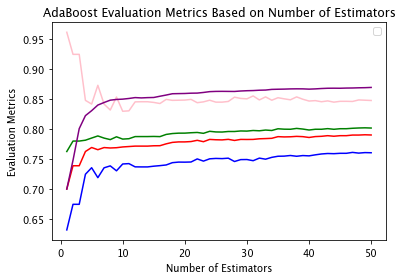

In [538]:
## plot all evaluation metrics as y values with estimator as x 
plt.plot(n_estimators, ada_metrics.Accuracy, color="red")
plt.plot(n_estimators, ada_metrics.Precision, color="blue")
plt.plot(n_estimators, ada_metrics.Recall, color="pink")
plt.plot(n_estimators, ada_metrics['F1 Score'], color="green")
plt.plot(n_estimators, ada_metrics.AUC, color="purple")
plt.legend()
plt.xlabel('Number of Estimators')
plt.ylabel('Evaluation Metrics')
plt.title('AdaBoost Evaluation Metrics Based on Number of Estimators')